In [2]:
# ----- Import required packages -----
import netCDF4
import numpy as np
import os
from scipy import io
import matplotlib.pyplot as plt
## Import necessary modules, libraries
import os.path
from datetime import datetime
import xarray as xr
import rasterio as rio
import datetime as dt
import matplotlib
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.cluster.vq import kmeans2
from scipy.stats import iqr, mode
from sklearn.cluster import KMeans
import hvplot.pandas

In [3]:
dir = Path('/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee')
output_file_name = "Hoover"
DataFolder = dir / 'raw_hoover' 
OutDataFolder = dir / 'output'

pass_num = 496
lat_min = 36.04
lat_max = 36.11

In [4]:
def detect_missing_data(var_FillValue, data):
    if data==var_FillValue:
        data_Flag=1
    else:
        data_Flag=0
    return data_Flag

Code to process each swot file and generate altimeter heights.

In [5]:
lat_boundary=[lat_min, lat_max]
DataFolder2=DataFolder
OutDataFolder2=OutDataFolder

if len(str(pass_num))==1:
    pass_num2=("00"+str(pass_num))
elif len(str(pass_num))==2:
    pass_num2=("0"+str(pass_num))
else:
    pass_num2=(str(pass_num))

secd2day=86400 #secd2day=1/86400
mjd_of_time_org=51544
filename = "SWOT_%s_IPN_%s_%.6f_%.6f_info" %(pass_num2,str(output_file_name),lat_boundary[0],lat_boundary[1])
savepath = OutDataFolder2 / filename
savepath.mkdir(parents=True, exist_ok=True)
extracted_elevation_fp = savepath / f"{filename}.txt"
print(f"Saving data to {extracted_elevation_fp}")
text_file = open(extracted_elevation_fp, "w") # output wll be saved here


def process_swot_file(filepath, lat_boundary=lat_boundary):
  cycno = filepath.name.split('_')[2][-3:]
  data=netCDF4.Dataset(filepath, 'r')
  elevations = []

  time_01 = data.groups['data_01']['time'][:]
  dim_01hz=len(time_01)
  time_intv1=time_01-0.5
  time_intv2=time_01+0.5
  time20ku= data.groups['data_20']['time'][:]
  dim_20hz=len(time20ku)
  mjd_20_ku = (time20ku/secd2day)+mjd_of_time_org
  lon= data.groups['data_20']['longitude'][:]
  lat= data.groups['data_20']['latitude'][:]

  # Geophysical Corrections
  poletide= data.groups['data_01']['pole_tide'][:]
  solid_earth_tide= data.groups['data_01']['solid_earth_tide'][:]

  # Atmospheric Corrections
  iono_cor_alt= data.groups['data_01']['ku']['iono_cor_alt'][:]
  iono_cor_gim= data.groups['data_01']['ku']['iono_cor_gim'][:]

  mod_dry_tropo_cor_meas= data.groups['data_01']['model_dry_tropo_cor_measurement_altitude'][:]
  # mod_dry_tropo_cor_zero= data.groups['data_20']['model_dry_tropo_cor_zero_altitude'][:]
  mod_wet_tropo_cor_meas= data.groups['data_01']['model_wet_tropo_cor_measurement_altitude'][:]
  # mod_wet_tropo_cor_zero= data.groups['data_20']['model_wet_tropo_cor_zero_altitude'][:]

  # Satellite Altitude
  altimetry= data.groups['data_20']['altitude'][:]
  # Ice Retracking
  range_ice= data.groups['data_20']['ku']['range_ice2'][:]
  sig0_ice= data.groups['data_20']['ku']['sig0_ice2'][:]
  # Ocean Retracking
  range_ocean= data.groups['data_20']['ku']['range_ocean'][:]
  sig0_ocean= data.groups['data_20']['ku']['sig0_ocean'][:]
  range_ocean_flag= data.groups['data_20']['ku']['range_ocean_compression_qual'][:]
  sig0_ocean_flag= data.groups['data_20']['ku']['sig0_ocean_compression_qual'][:]
  # OCOG Retracking
  range_ocog= data.groups['data_20']['ku']['range_ocog'][:]
  sig0_ocog= data.groups['data_20']['ku']['sig0_ocog'][:]
  range_mle3= data.groups['data_20']['ku']['range_ocean_mle3'][:]
  sig0_mle3= data.groups['data_20']['ku']['sig0_ocean_mle3'][:]
  # Sea-Ice Retracking
  range_sea_ice= data.groups['data_20']['ku']['range_seaice'][:]
  sig0_sea_ice= data.groups['data_20']['ku']['sig0_seaice'][:]

  # Surface Class/Type
  surf_class= data.groups['data_20']['surface_classification_flag'][:]

  sel_range = range_ocog.copy()
  sel_sig0 = sig0_ocog.copy()

  ## Fill Value
  pole_tide_01_FillValue=32767
  solid_earth_tide_01_FillValue=32767
  iono_cor_gim_01_ku_FillValue=32767
  mod_dry_tropo_cor_meas_altitude_01_FillValue=32767
  mod_wet_tropo_cor_meas_altitude_01_FillValue=32767

  alt_FillValue=2147483647
  range_FillValue=2147483647
  sig0_FillValue=32767
  elev_FillValue=2147483647

  for i in range(dim_01hz):
    pole_tide_Flag=detect_missing_data(pole_tide_01_FillValue,poletide[i])
    solid_earth_tide_Flag=detect_missing_data(solid_earth_tide_01_FillValue,solid_earth_tide[i])
    iono_cor_gim_ku_Flag=detect_missing_data(solid_earth_tide_01_FillValue,iono_cor_gim[i])
    mod_dry_tropo_cor_meas_altitude_Flag=detect_missing_data(solid_earth_tide_01_FillValue,mod_dry_tropo_cor_meas[i])
    mod_wet_tropo_cor_meas_altitude_Flag=detect_missing_data(solid_earth_tide_01_FillValue,mod_wet_tropo_cor_meas[i])

    correction=poletide[i]+solid_earth_tide[i]+iono_cor_gim[i]+mod_dry_tropo_cor_meas[i]+mod_wet_tropo_cor_meas[i]
    Flags=pole_tide_Flag+solid_earth_tide_Flag+iono_cor_gim_ku_Flag+mod_dry_tropo_cor_meas_altitude_Flag+mod_wet_tropo_cor_meas_altitude_Flag
    mtone = np.where(lat>=lat_boundary[0])
    mttwo = np.where(lat<=lat_boundary[1])
    idxarry = np.intersect1d(mtone,mttwo)
    for j in idxarry:
      alt_F=detect_missing_data(alt_FillValue,altimetry[j])
      range_F=detect_missing_data(range_FillValue,sel_range[j])
      sig0_F=detect_missing_data(sig0_FillValue,sel_sig0[j])

      Flags1=Flags
      Flags2=Flags1+alt_F+range_F+sig0_F
      if Flags2 == 0: 
        if time20ku[j]>=time_intv1[i] and time20ku[j]<=time_intv2[i]:
          correction2=correction
          hgt_20hz=altimetry[j]-(correction2+sel_range[j])
          mjd_20hz=mjd_20_ku[j]
          lon_20hz=lon[j]
          lat_20hz=lat[j]
          sig0_20hz=sig0_ocog[j]
          if hgt_20hz!=np.nan: # and np.abs(hgt_20hz - elev_ocog[j])<=10: ##
              elevations.append((0, 0, 0, 0, 0, 0, 0, 0, 0, cycno, mjd_20hz, lon_20hz, lat_20hz, hgt_20hz, sig0_20hz))
  return elevations

##  Process all files in the data folder
allpath=list(DataFolder2.glob(f'*_GPN_*_{pass_num2}_*.nc'))

versionstr = allpath[0].name.split('_')[2]
cycno = versionstr[-3:]

ct_total_cycle = 0
cycle_list=[]
finalpath =[]
for i in range(len(allpath)):
  allpath1 = Path(allpath[i])
  versionstr = allpath1.name.split('_')[2]
  cycno=versionstr[-3:]
  cycle_list.append(cycno)
  finalpath.append(allpath1)

cycle_list = np.array(cycle_list)
ct_total_cycle = len(cycle_list)

print('Total number of cycles: ', ct_total_cycle)

# for i in tqdm(range(len(finalpath))):
#   datapath = DataFolder / finalpath[i]
#   processed_elevation_info = process_swot_file(datapath)
#   for elevation_line in processed_elevation_info:
#     text_file.write("%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%20.6f\t%20.6f\t%20.6f\t%20.6f\t%10.3f\n" % elevation_line)

text_file.close()
print('Data Extraction complete')

Saving data to /tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/output/SWOT_496_IPN_Hoover_36.040000_36.110000_info/SWOT_496_IPN_Hoover_36.040000_36.110000_info.txt
Total number of cycles:  13
Data Extraction complete


<Axes: >

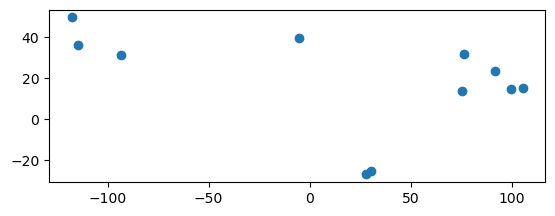

In [6]:
import geopandas as gpd

# read the} bounding box of the study area
val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation-pts.geojson'))
val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/mini-reservoirs-subset-validation.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
    '1078' # Lake Mead, US
]
res_names = {
    '0505': 'Dumboor, In',
    '0810': 'Sirindhorn, Th',
    '0830': 'Krasoew, Th',
    '0502': 'Bhakra, In',
    '0518': 'Bhadra, In',
    '0349': 'Vaaldam, SA',
    '0464': 'Sterkspruit, SA',
    '0214': 'Cijara, Sp',
    '1498': 'Toledo Bend, US',
    '0936': 'Arrow, Ca',
    '1078': 'Lake Mead, US'
}

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [7]:
start_date = '2022-01-01'
end_date = '2024-07-01'
RESERVOIR = '1078'
buffer_amt = 50 # meters. unlike other types of data, nadir altimetry data works better with a smaller buffer around the reservoir. 
                 # The exact boundary of the reservoir is ideal, but is difficult to obtain automatically, so 50m buffer is a good compromise.
RESERVOIR_NAME = res_names[RESERVOIR]
print(f'{RESERVOIR}: {RESERVOIR_NAME}')

1078: Lake Mead, US


In [9]:
import hvplot.pandas
import geoviews as gv

swot_nadir_tracks_fp = Path("/tiger1/pdas47/tmsosPP/data/swot_orbit/sph_science_nadir/swot_science_orbit_sept2015-v2_nadir.shp")

roi = val_res_poly[val_res_poly['tmsos_id']==RESERVOIR]
utm_crs = roi.estimate_utm_crs()
buffered_roi_utm = roi.to_crs(utm_crs).geometry.buffer(buffer_amt)
buffered_roi = buffered_roi_utm.to_crs('epsg:4326')

# get lat-lon boundary
gd_track = gpd.read_file(swot_nadir_tracks_fp)
gd_track_subset = gd_track[gd_track.intersects(roi.geometry.values[0])]

roi.hvplot(geo=True) * gd_track_subset.hvplot(geo=True, color='red')

:Overlay
   .Polygons.I :Polygons   [Longitude,Latitude]
   .Path.I     :Path   [Longitude,Latitude]

In [10]:
# ----- Functions of processing -----
# Deoutlier functions
def iqr_deoutlier(cyc_hgt_profile):
    IQR = iqr(cyc_hgt_profile, nan_policy='omit')
    high_prct = np.nanquantile(cyc_hgt_profile, 0.75)
    low_prct = np.nanquantile(cyc_hgt_profile, 0.25)
    index_retain_iqr = np.logical_and(cyc_hgt_profile>low_prct-1.5*IQR, cyc_hgt_profile<high_prct+1.5*IQR).flatten()

    return index_retain_iqr

def kmean_water_cluster(cyc_hgt_profile, cyc_sig_profile, hgt_cyc_range_thrd, hgt_cyc_std_thrd):
    hgt_cyc_range = np.nanmax(cyc_hgt_profile) - np.nanmin(cyc_hgt_profile)
    while hgt_cyc_range > hgt_cyc_range_thrd:
        kmeans_cluster = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(cyc_hgt_profile)
        cyc_hgt_profile = cyc_hgt_profile[kmeans_cluster==mode(kmeans_cluster, keepdims=True)[0]]
        cyc_sig_profile = cyc_sig_profile[kmeans_cluster==mode(kmeans_cluster, keepdims=True)[0]]
        hgt_cyc_range = np.nanmax(cyc_hgt_profile) - np.nanmin(cyc_hgt_profile)

    hgt_cyc_mean = np.nanmean(cyc_hgt_profile)
    hgt_cyc_std = np.nanstd(cyc_hgt_profile)
    hgt_cyc_errmean = cyc_hgt_profile[:,0] - hgt_cyc_mean
    while hgt_cyc_std > hgt_cyc_std_thrd:
        if np.count_nonzero(~np.isnan(cyc_hgt_profile))==2:
            break
        hgt_cyc_errmean = cyc_hgt_profile - hgt_cyc_mean
        cyc_hgt_profile = cyc_hgt_profile[np.abs(hgt_cyc_errmean)!=np.nanmax(np.abs(hgt_cyc_errmean))]
        cyc_sig_profile = cyc_sig_profile[np.abs(hgt_cyc_errmean)!=np.nanmax(np.abs(hgt_cyc_errmean))]
        hgt_cyc_std = np.nanstd(cyc_hgt_profile)
        hgt_cyc_mean = np.nanmean(cyc_hgt_profile)

    return cyc_hgt_profile, cyc_sig_profile

def decimal_years_to_calendar(excel_date):
  formatted_dates = []

  for decimal_year in excel_date:
    year = int(decimal_year)
    days_fraction = (decimal_year) - (year)
    start_date = datetime(year, 1, 1)
    end_date = datetime(year + 1, 1, 1)
    delta = end_date - start_date

    result_date = start_date + timedelta(days=(days_fraction * delta.days)-1)
    formatted_date = result_date.strftime('%Y-%m-%d')
    formatted_dates.append(formatted_date)

  return formatted_dates

def get_time_series(input_data, index_retain, hgt_cyc_range_thrd, hgt_cyc_std_thrd):
    input_data = input_data[index_retain,:]
    cycno_list = input_data[:,0]
    uniq_cycno = np.unique(cycno_list)

    ct_cyc=0
    FinalSeries=np.empty((len(uniq_cycno),8))
    FinalSeries[:]=np.nan
    for cycno in uniq_cycno[:]:

        index_cyc = cycno_list==cycno
        cyc_data = input_data[index_cyc,:]

        mjd = cyc_data[:,1].reshape(-1,1)
        lon = cyc_data[:,2].reshape(-1,1)
        lat = cyc_data[:,3].reshape(-1,1)
        hgt = cyc_data[:,4].reshape(-1,1)
        sig = cyc_data[:,5].reshape(-1,1)

        hgt, sig = kmean_water_cluster(hgt, sig, hgt_cyc_range_thrd, hgt_cyc_std_thrd)

        cyc_time = (np.nanmean(mjd)+2108-50000)/365.25 +1990
        cyc_lon = np.nanmean(lon)
        cyc_lat = np.nanmean(lat)

        cyc_hgt = np.nanmean(hgt)
        #cyc_unc_hgt = uncertainty(hgt)
        cyc_std_hgt = np.nanstd(hgt)
        cyc_sig = np.nanmean(sig)
        cyc_retain_rate = hgt.shape[0] / cyc_data.shape[0]

        FinalSeries[ct_cyc,:] = [cycno, cyc_time, cyc_lon, cyc_lat, cyc_hgt, cyc_std_hgt, cyc_sig, cyc_retain_rate]

        ct_cyc=ct_cyc+1

    return FinalSeries

def get_time_series_egm08(ip, FinalSeries):
    ## Time-series of water levels (convert to w.r.t. EGM-2008)
    N=ip((FinalSeries[:,3],FinalSeries[:,2]))
    FinalSeries[:,4]=FinalSeries[:,4]-N

    egm08_timeseries = FinalSeries[:,[0,4,5,1,2,3]]

    return egm08_timeseries

In [11]:
from scipy.interpolate import RegularGridInterpolator

outputdir = '/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/output' #Enter the path that you want the output be saved.

# Setting in cluster refinement (Okeowo et al., 2017)
hgt_cyc_range_thrd = 5
hgt_cyc_std_thrd = 0.3

# ----- Main function -----
def okeowo_2017(extracted_elevations_fp, min_lat, max_lat, hgt_cyc_range_thrd=5, hgt_cyc_std_thrd=0.3, egm2008_fp="/tiger1/pdas47/tmsosPP/data/geoid/geoidegm2008grid.mat"):
  module1 = extracted_elevations_fp  # extracted path
  module2 = min_lat
  module3 = max_lat

  DataFolder2 = module1

  lat_min = float(module2)
  lat_max = float(module3)

  lat_boundary = [lat_min, lat_max]

  # please input the path of the EGM2008
  lonbp = io.loadmat(egm2008_fp)['lonbp']
  latbp = io.loadmat(egm2008_fp)['latbp']
  grid=io.loadmat(egm2008_fp)['grid']

  ip=RegularGridInterpolator(points=(latbp.flatten(),lonbp.flatten()), values=grid, bounds_error=False, fill_value=np.nan)

  # 4. Altimetry data
  try:
    input_data = np.loadtxt(DataFolder2)[:,9:]
    lat_all=input_data[:,3]
    index_lat_range = np.logical_and(lat_all>lat_boundary[0], lat_all<lat_boundary[1])
    input_data=input_data[index_lat_range,:]

    lon_all = input_data[:,2].reshape(-1,1)
    lat_all = input_data[:,3].reshape(-1,1)
    hgt_all = input_data[:,4].reshape(-1,1)
  except:
    input_data = np.loadtxt(DataFolder2)[9:]

    lat_all=input_data[3]
    index_lat_range = np.logical_and(lat_all>lat_boundary[0], lat_all<lat_boundary[1])
    input_data=input_data[index_lat_range]

    lon_all = input_data[0][2]
    lat_all = input_data[0][3]
    hgt_all = input_data[0][4]

  index_retain_iqr = iqr_deoutlier(hgt_all)
  FinalSeries_iqr = get_time_series(input_data, index_retain_iqr, hgt_cyc_range_thrd, hgt_cyc_std_thrd)

  egm08_timeseries = get_time_series_egm08(ip, FinalSeries_iqr)

  # convert to dataframe
  df = pd.DataFrame(egm08_timeseries, columns=['cycle', 'wse_egm08', 'uncertainty', 'time', 'lon', 'lat'])

  return df

# swot_nadir_timeseries = okeowo_2017(
#   extracted_elevation_fp, lat_min, lat_max, 
#   hgt_cyc_range_thrd, hgt_cyc_std_thrd, 
#   egm2008_fp="/tiger1/pdas47/tmsosPP/data/geoid/geoidegm2008grid.mat"
# )
# swot_nadir_timeseries

In [12]:
# swot_nadir_timeseries.plot(
#     x='time', y='wse_egm08', kind='scatter'
# )

In [13]:
def swot_nadir_altimeter(
        roi, start_date, end_date,
        intersection_length_threshold=300, # meters. jason class altimeters require at least 300 m of intersection with the ROI.
        swot_nadir_tracks_fp = Path("/tiger1/pdas47/tmsosPP/data/swot_orbit/sph_science_nadir/swot_science_orbit_sept2015-v2_nadir.shp"),
        swot_nadir_raw_dir = Path("/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/raw"),
        swot_nadir_extracted_dir = Path("/tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/extracted")
    ):
    # create output directory if it doesn't exist
    swot_nadir_extracted_dir.mkdir(exist_ok=True)

    # get lat-lon boundary
    gd_track = gpd.read_file(swot_nadir_tracks_fp)
    gd_track_subset = gd_track[gd_track.intersects(roi.geometry.values[0])]

    # filter by intersection length threshold
    nadir_intersects = gpd.GeoDataFrame(geometry=gd_track_subset.intersection(roi.geometry.values[0]).explode(index_parts=False)) # explode = split multi-geometry into single geometries
    nadir_intersects['intersect_length_m'] = nadir_intersects.to_crs(roi.estimate_utm_crs()).length
    nadir_intersects = nadir_intersects[nadir_intersects['intersect_length_m'] > intersection_length_threshold]
    nadir_intersects['pass_num'] = gd_track_subset['ID_PASS'].loc[nadir_intersects.index]
    nadir_intersects['min_lat'] = nadir_intersects.bounds['miny']
    nadir_intersects['max_lat'] = nadir_intersects.bounds['maxy']
    
    swot_nadir_timeseries_all = []
    # for each pass in ROI, extract data
    for idx, row in nadir_intersects.iterrows():
        extracted_elevations_fp = swot_nadir_extracted_dir / f"SWOT_{RESERVOIR}_{row['pass_num']}_{row['min_lat']}_{row['max_lat']}_info.txt"
        pass_num = row['pass_num']
        lat_min = row['min_lat']
        lat_max = row['max_lat']
        intersect_length = row['intersect_length_m']

        swot_nadir_fps = Path(swot_nadir_raw_dir).glob(f'SWOT_GPN_*_{pass_num:03}_*.nc')
        # filter by start and end date
        swot_nadir_fps = filter(
            lambda fp: pd.to_datetime(fp.name.split('_')[4], format='%Y%m%d') >= pd.to_datetime(start_date) \
                and pd.to_datetime(fp.name.split('_')[4], format='%Y%m%d') <= pd.to_datetime(end_date),
            swot_nadir_fps
        )
        with open(extracted_elevations_fp, "w") as text_file:
            print(f"writing to {extracted_elevations_fp}")
            for fp in swot_nadir_fps:
                processed_elevation_info = process_swot_file(fp, lat_boundary=[lat_min, lat_max])
                for elevation_line in processed_elevation_info:
                    text_file.write("%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%4s\t%20.6f\t%20.6f\t%20.6f\t%20.6f\t%10.3f\n" % elevation_line)

        swot_nadir_timeseries = okeowo_2017(
            extracted_elevations_fp, lat_min, lat_max, 
            hgt_cyc_range_thrd, hgt_cyc_std_thrd, 
            egm2008_fp="/tiger1/pdas47/tmsosPP/data/geoid/geoidegm2008grid.mat"
        )
        swot_nadir_timeseries['pass_num'] = pass_num
        swot_nadir_timeseries['intersect_length_m'] = intersect_length
        swot_nadir_timeseries_all.append(swot_nadir_timeseries)

    return pd.concat(swot_nadir_timeseries_all)

swot_elevations = swot_nadir_altimeter(
    roi=buffered_roi,
    start_date=start_date,
    end_date=end_date
)
swot_elevations

writing to /tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/extracted/SWOT_1078_205_36.011383523900015_36.02043380392582_info.txt
writing to /tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/extracted/SWOT_1078_205_36.02111494885451_36.126072309012834_info.txt
writing to /tiger1/pdas47/tmsosPP/data/swot_nadir_hlee/extracted/SWOT_1078_496_36.018940200063_36.02364893317846_info.txt


,cycle,wse_egm08,uncertainty,time,lon,lat,pass_num,intersect_length_m
0,1.0,323.617230,0.323400,2023.570282,245.845219,36.017235,205,1026.599558
1,2.0,324.157282,0.201850,2023.627406,245.837927,36.015233,205,1026.599558
2,3.0,324.754739,0.155250,2023.684530,245.838974,36.016022,205,1026.599558
3,4.0,325.150077,0.175150,2023.741654,245.847543,36.015243,205,1026.599558
4,5.0,325.002820,0.013600,2023.798779,245.842573,36.015859,205,1026.599558
5,6.0,323.968395,0.327000,2023.855903,245.838139,36.015561,205,1026.599558
6,7.0,324.500149,0.081500,2023.913027,245.840569,36.014935,205,1026.599558
7,8.0,325.554603,0.165850,2023.970151,245.846328,36.014609,205,1026.599558
8,9.0,326.123547,0.035267,2024.027276,245.844729,36.014792,205,1026.599558
9,10.0,326.901986,0.241977,2024.084400,245.841881,36.015075,205,1026.599558


In [14]:
def weighted_avg(group_df, whole_df, values, weights):
    v = whole_df.loc[group_df.index, values]
    w = whole_df.loc[group_df.index, weights]
    return (v * w).sum() / w.sum()

elevations_avg = swot_elevations.groupby(['cycle', 'pass_num']).agg({"wse_egm08": 'mean', "time": "mean"}).reset_index()
elevations_avg

,cycle,pass_num,wse_egm08,time
0,1.0,205,323.788644,2023.570282
1,1.0,496,324.179054,2023.598706
2,2.0,205,324.331968,2023.627406
3,3.0,205,325.175703,2023.684530
4,4.0,205,325.328648,2023.741654
5,4.0,496,325.249371,2023.770078
6,5.0,205,325.213859,2023.798779
7,5.0,496,325.194029,2023.827203
8,6.0,205,324.288910,2023.855903
9,6.0,496,325.008379,2023.884327


In [15]:
elevations_avg.hvplot(
    x='time', y='wse_egm08', kind='scatter', by='pass_num'
).opts(
    title="Lake Mead elevations - SWOT NADIR altimeter"
)

:NdOverlay   [pass_num]
   :Scatter   [time]   (wse_egm08)

In [16]:
swot_elevations.hvplot(
    x='lon', y='lat', color='wse_egm08', kind='points', geo=True, tiles='ESRI', cmap='brg'
)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (wse_egm08)

In [17]:
swot_elevations.hvplot(
    x='time', y='wse_egm08', color='pass_num', kind='scatter', cmap='bwr', clabel='Pass Number',
).opts(
    title='Lake Mead - SWOT Nadir altimeter. Multiple intersections over same pass',
    xlabel='Time (decimal year)', ylabel='Water Surface Elevation (m)'
)

:Scatter   [time]   (wse_egm08,pass_num)